Successfully loaded p_controller_log.csv
      timestamp    x_pos    y_pos  current_distance     error  control_speed
0  1.752725e+09 -0.00006  0.00006          0.000085  1.999915       1.999915
1  1.752725e+09 -0.00006  0.00003          0.000067  1.999933       1.999933
2  1.752725e+09 -0.00006  0.00004          0.000072  1.999928       1.999928
3  1.752725e+09 -0.00006  0.00004          0.000072  1.999928       1.999928
4  1.752725e+09 -0.00001  0.00005          0.000051  1.999949       1.999949

Graph has been saved as controller_performance_plot.png


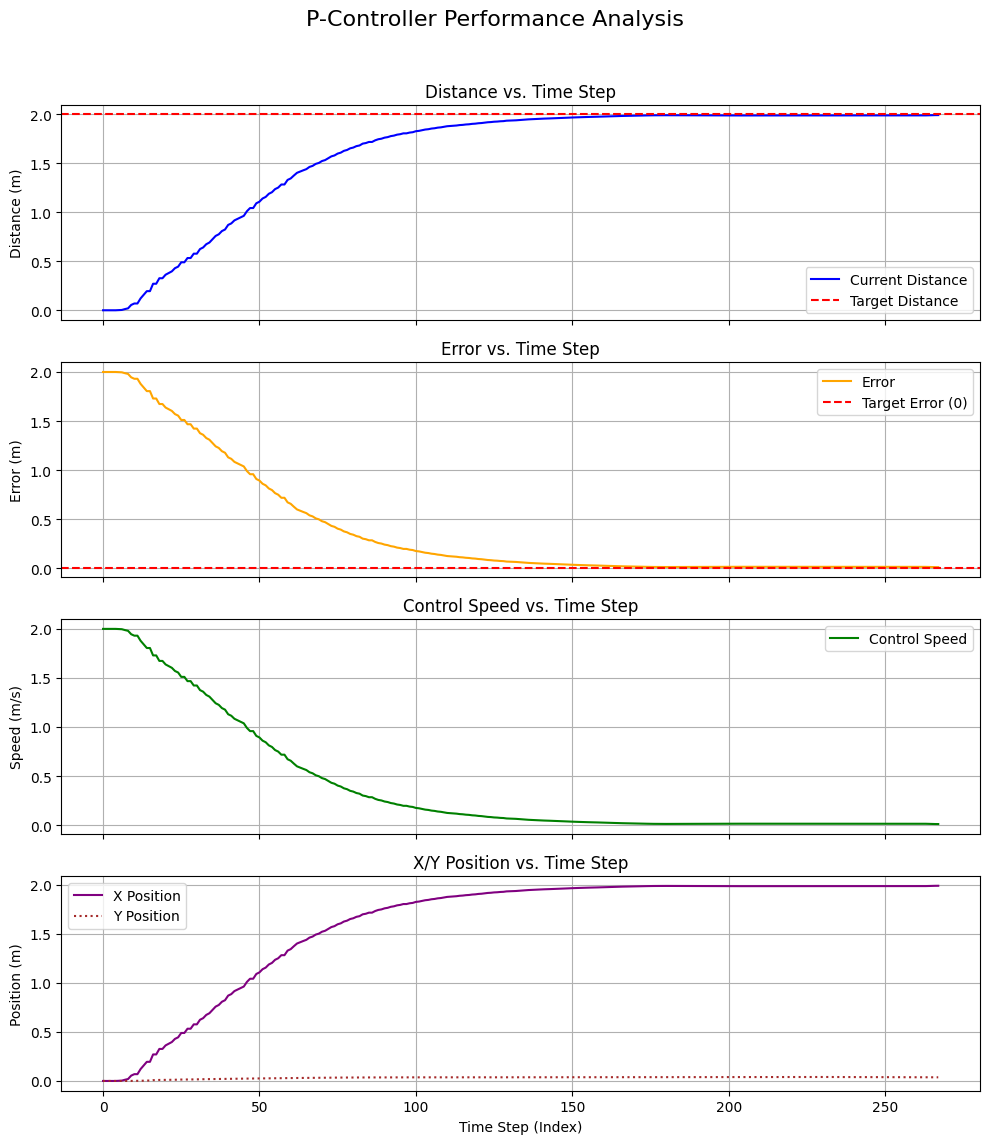

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. อ่านข้อมูลจากไฟล์ CSV ---
try:
    # อ่านไฟล์ CSV ที่เราบันทึกไว้
    df = pd.read_csv("p_controller_full_log.csv")
    print("Successfully loaded p_controller_log.csv")
    print(df.head()) # แสดง 5 แถวแรกเพื่อตรวจสอบ
except FileNotFoundError:
    print("Error: p_controller_log.csv not found. Please run the robot controller script first.")
    exit()

# --- 2. สร้างกราฟ ---

# สร้าง Figure และ Subplots ทั้งหมด 4 กราฟเรียงกันในแนวตั้ง
# figsize=(10, 12) คือขนาดของรูปภาพทั้งหมด (กว้าง 10 นิ้ว, สูง 12 นิ้ว)
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
fig.suptitle('P-Controller Performance Analysis', fontsize=16)

# กราฟที่ 1: ระยะทาง (Distance)
axs[0].plot(df.index, df['current_distance'], label='Current Distance', color='blue')
# เพิ่มเส้นเป้าหมาย
axs[0].axhline(y=df['current_distance'].iloc[-1] + df['error'].iloc[-1], color='r', linestyle='--', label='Target Distance')
axs[0].set_ylabel('Distance (m)')
axs[0].set_title('Distance vs. Time Step')
axs[0].legend()
axs[0].grid(True)

# กราฟที่ 2: ค่าความผิดพลาด (Error)
axs[1].plot(df.index, df['error'], label='Error', color='orange')
axs[1].axhline(y=0, color='r', linestyle='--', label='Target Error (0)')
axs[1].set_ylabel('Error (m)')
axs[1].set_title('Error vs. Time Step')
axs[1].legend()
axs[1].grid(True)

# กราฟที่ 3: ความเร็วที่ใช้ควบคุม (Control Speed)
axs[2].plot(df.index, df['control_speed'], label='Control Speed', color='green')
axs[2].set_ylabel('Speed (m/s)')
axs[2].set_title('Control Speed vs. Time Step')
axs[2].legend()
axs[2].grid(True)

# กราฟที่ 4: ตำแหน่ง X และ Y
axs[3].plot(df.index, df['x_pos'], label='X Position', color='purple')
axs[3].plot(df.index, df['y_pos'], label='Y Position', color='brown', linestyle=':')
axs[3].set_xlabel('Time Step (Index)')
axs[3].set_ylabel('Position (m)')
axs[3].set_title('X/Y Position vs. Time Step')
axs[3].legend()
axs[3].grid(True)

# --- 3. แสดงผลและบันทึกไฟล์ ---
plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # ปรับ layout ให้สวยงาม
plt.savefig("controller_performance_plot.png") # บันทึกกราฟเป็นไฟล์รูปภาพ
print("\nGraph has been saved as controller_performance_plot.png")
plt.show() # แสดงกราฟขึ้นมาบนหน้าจอ

In [ ]:
from robomaster import robot
import time
import math
import pandas as pd

# --- 1. โครงสร้างสำหรับเก็บข้อมูลตำแหน่งล่าสุด ---
robot_position = {'x': 0, 'y': 0, 'z': 0}

def position_handler(position_info):
    """ฟังก์ชันที่จะถูกเรียกทุกครั้งที่ได้รับข้อมูลตำแหน่งใหม่"""
    x, y, z = position_info
    robot_position['x'] = x
    robot_position['y'] = y

# --- 2. ส่วนการทำงานหลัก ---
if __name__ == '__main__':
    ep_robot = robot.Robot()
    ep_robot.initialize(conn_type="ap")
    ep_chassis = ep_robot.chassis

    # Subscribe เพื่อรับข้อมูลตำแหน่งแบบต่อเนื่อง
    ep_chassis.sub_position(freq=50, callback=position_handler)
    time.sleep(1) # รอให้ subscription เริ่มทำงาน

    # --- พารามิเตอร์ของ Controller ---
    target_distance = 2.0  # เป้าหมายคือเคลื่อนที่ไปข้างหน้า 2 เมตร
    Kp = 1             # อัตราขยาย (Gain)
    tolerance = 0.01       # ค่าความคลาดเคลื่อนที่ยอมรับได้ (1 ซม.)

    # สร้าง List สำหรับเก็บ Log
    log_data = []

    print(f"Starting P-Controller to reach {target_distance} m...")

    # --- Control Loop (ควบคุมการเคลื่อนที่ทั้งหมด) ---
    while True:
        # คำนวณระยะทางปัจจุบันจากจุดเริ่มต้น
        current_distance = math.sqrt(robot_position['x']**2 + robot_position['y']**2)
        
        # คำนวณ Error (ระยะทางที่ยังขาดไป)
        error = target_distance - current_distance
        
        # ตรวจสอบว่าถึงเป้าหมายแล้วหรือยัง
        if abs(error) < tolerance:
            print(f"Target reached! Final distance: {current_distance:.3f} m")
            ep_chassis.stop() # สั่งให้หุ่นยนต์หยุด
            break # ออกจาก Loop
        
        # P-Controller: คำนวณความเร็วจาก Error
        control_speed = Kp * error

        # สั่งให้หุ่นยนต์เคลื่อนที่ด้วยความเร็วที่คำนวณได้
        ep_chassis.drive_speed(x=control_speed, y=0, z=0)
        
        print(f"Target: {target_distance:.2f} | Current: {current_distance:.2f} | Error: {error:.2f} | Speed: {control_speed:.2f}")

        # บันทึกข้อมูลในแต่ละรอบ
        log_entry = {
            'timestamp': time.time(),
            'x_pos': robot_position['x'],
            'y_pos': robot_position['y'],
            'current_distance': current_distance,
            'error': error,
            'control_speed': control_speed
        }
        log_data.append(log_entry)
        
        # หน่วงเวลาให้สอดคล้องกับ Freq ของ subscription
        time.sleep(1 / 50) 

    # บันทึก List เป็นไฟล์ CSV
    if log_data:
        df = pd.DataFrame(log_data)
        file_name = "p_controller_full_log.csv"
        df.to_csv(file_name, index=False)
        print(f"\nLog data successfully saved to {file_name}")

    # จบการทำงาน
    ep_chassis.unsub_position()
    ep_robot.close()

Starting P-Controller to reach 2.0 m...
Target: 2.00 | Current: 0.00 | Error: 2.00 | Speed: 2.00
Target: 2.00 | Current: 0.00 | Error: 2.00 | Speed: 2.00
Target: 2.00 | Current: 0.00 | Error: 2.00 | Speed: 2.00
Target: 2.00 | Current: 0.00 | Error: 2.00 | Speed: 2.00
Target: 2.00 | Current: 0.00 | Error: 2.00 | Speed: 2.00
Target: 2.00 | Current: 0.00 | Error: 2.00 | Speed: 2.00
Target: 2.00 | Current: 0.00 | Error: 2.00 | Speed: 2.00
Target: 2.00 | Current: 0.01 | Error: 1.99 | Speed: 1.99
Target: 2.00 | Current: 0.02 | Error: 1.98 | Speed: 1.98
Target: 2.00 | Current: 0.05 | Error: 1.95 | Speed: 1.95
Target: 2.00 | Current: 0.07 | Error: 1.93 | Speed: 1.93
Target: 2.00 | Current: 0.07 | Error: 1.93 | Speed: 1.93
Target: 2.00 | Current: 0.12 | Error: 1.88 | Speed: 1.88
Target: 2.00 | Current: 0.16 | Error: 1.84 | Speed: 1.84
Target: 2.00 | Current: 0.20 | Error: 1.80 | Speed: 1.80
Target: 2.00 | Current: 0.20 | Error: 1.80 | Speed: 1.80
Target: 2.00 | Current: 0.27 | Error: 1.73 | Spe

In [11]:
from robomaster import robot
import time
import math
import pandas as pd

# --- 1. โครงสร้างสำหรับเก็บข้อมูลตำแหน่งล่าสุด ---
robot_position = {'x': 0, 'y': 0, 'z': 0}

def position_handler(position_info):
    """ฟังก์ชันที่จะถูกเรียกทุกครั้งที่ได้รับข้อมูลตำแหน่งใหม่"""
    x, y, z = position_info
    robot_position['x'] = x
    robot_position['y'] = y

# --- 2. ส่วนการทำงานหลัก ---
if __name__ == '__main__':
    ep_robot = robot.Robot()
    ep_robot.initialize(conn_type="ap")
    ep_chassis = ep_robot.chassis

    ep_chassis.sub_position(freq=50, callback=position_handler)
    time.sleep(1)

    # --- พารามิเตอร์ของ Controller ---
    target_distance = 2.0
    Kp = 1  # ★ ปรับ Kp เพื่อเพิ่มความเร็วในการเข้าหาเป้าหมาย
    Kd = 0.01  # ★ เพิ่ม Kd เพื่อลดการแกว่งและ overshoot
    tolerance = 0.001

    log_data = []
    error = 1
    print(f"Starting PD-Controller to reach {target_distance} m...")

    last_error = 1
    time_step = 1 / 50

    # --- Control Loop ---
    while abs(error) > tolerance:
        current_distance = math.sqrt(robot_position['x']**2 + robot_position['y']**2)
        error = target_distance - current_distance

        
        derivative = (error - last_error) / time_step
        
        control_speed = (Kp * error) + (Kd * derivative)
        
        last_error = error
        
        ep_chassis.drive_speed(x=control_speed, y=0, z=0)
        
        print(f"Target: {target_distance:.2f} | Current: {current_distance:.2f} | Error: {error:.2f} | Speed: {control_speed:.2f}")

        # บันทึกข้อมูลในแต่ละรอบ
        log_entry = {
            'timestamp': time.time(),
            'x_pos': robot_position['x'],
            'y_pos': robot_position['y'],
            'current_distance': current_distance,
            'error': error,
            'derivative': derivative, 
            'control_speed': control_speed
        }
        log_data.append(log_entry)
        
        time.sleep(time_step) 


    if log_data:
        # df = pd.DataFrame(log_data)
        # file_name = "pd_controller_log.csv"
        # df.to_csv(file_name, index=False)
        print(f"\nLog data successfully saved to {file_name}")

    # จบการทำงาน
    ep_chassis.unsub_position()
    ep_robot.close()

Starting PD-Controller to reach 2.0 m...
Target: 2.00 | Current: 0.00 | Error: 2.00 | Speed: 2.50
Target: 2.00 | Current: 0.00 | Error: 2.00 | Speed: 2.00
Target: 2.00 | Current: 0.00 | Error: 2.00 | Speed: 2.00
Target: 2.00 | Current: 0.00 | Error: 2.00 | Speed: 2.00
Target: 2.00 | Current: 0.00 | Error: 2.00 | Speed: 2.00
Target: 2.00 | Current: 0.01 | Error: 1.99 | Speed: 1.99
Target: 2.00 | Current: 0.01 | Error: 1.99 | Speed: 1.99
Target: 2.00 | Current: 0.03 | Error: 1.97 | Speed: 1.97
Target: 2.00 | Current: 0.03 | Error: 1.97 | Speed: 1.97
Target: 2.00 | Current: 0.06 | Error: 1.94 | Speed: 1.92
Target: 2.00 | Current: 0.08 | Error: 1.92 | Speed: 1.91
Target: 2.00 | Current: 0.11 | Error: 1.89 | Speed: 1.87
Target: 2.00 | Current: 0.15 | Error: 1.85 | Speed: 1.83
Target: 2.00 | Current: 0.17 | Error: 1.83 | Speed: 1.82
Target: 2.00 | Current: 0.21 | Error: 1.79 | Speed: 1.77
Target: 2.00 | Current: 0.23 | Error: 1.77 | Speed: 1.76
Target: 2.00 | Current: 0.26 | Error: 1.74 | Sp

Successfully loaded p_controller_log.csv
      timestamp    x_pos    y_pos  current_distance     error  derivative  \
0  1.752726e+09 -0.00005  0.00005          0.000071  1.999929   99.996464   
1  1.752726e+09 -0.00005  0.00004          0.000064  1.999936    0.000334   
2  1.752726e+09 -0.00004  0.00004          0.000057  1.999943    0.000373   
3  1.752726e+09 -0.00005  0.00003          0.000058  1.999942   -0.000087   
4  1.752726e+09  0.00046 -0.00010          0.000471  1.999529   -0.020622   

   control_speed  
0            1.0  
1            1.0  
2            1.0  
3            1.0  
4            1.0  

Graph has been saved as controller_performance_plot.png


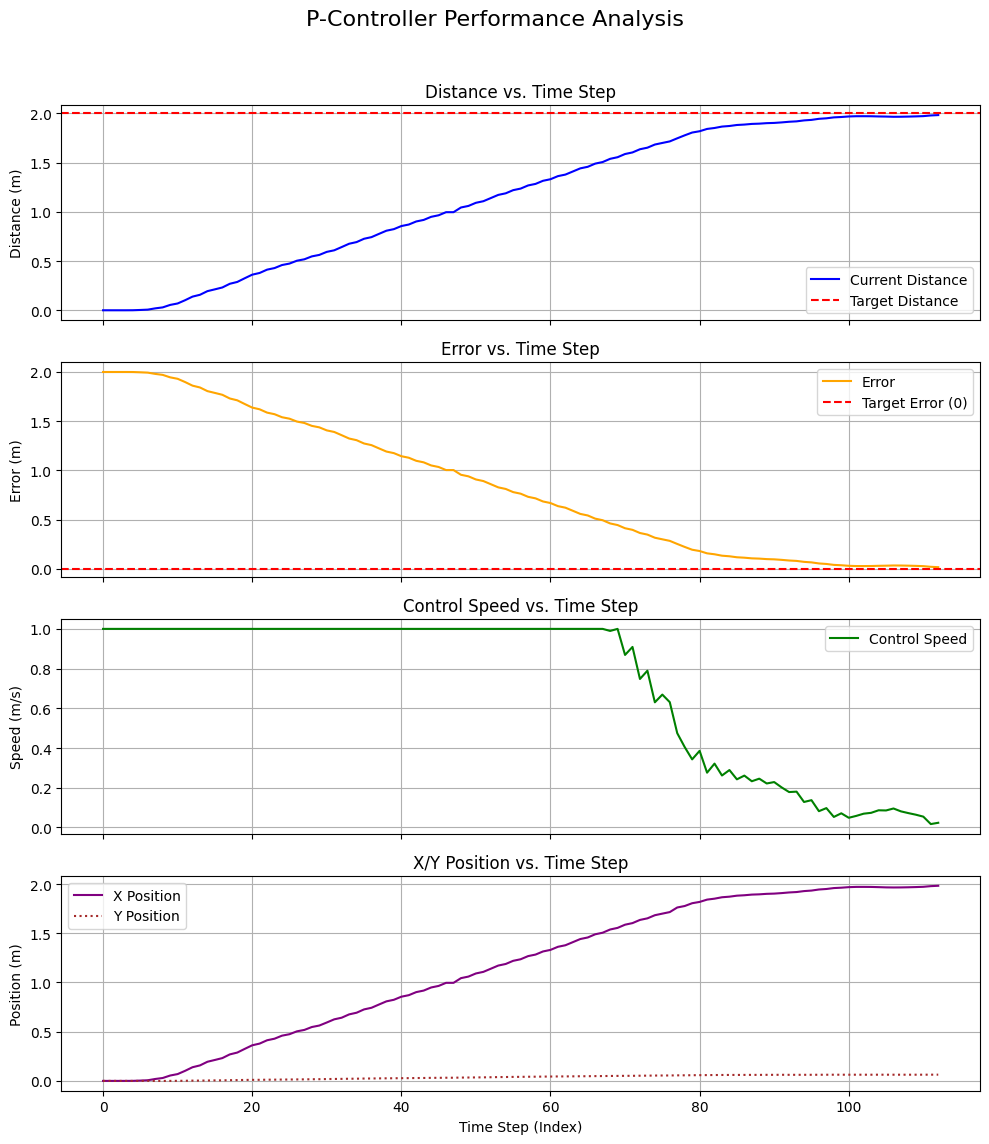

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. อ่านข้อมูลจากไฟล์ CSV ---
try:
    # อ่านไฟล์ CSV ที่เราบันทึกไว้
    df = pd.read_csv("pd_controller_log.csv")
    print("Successfully loaded p_controller_log.csv")
    print(df.head()) # แสดง 5 แถวแรกเพื่อตรวจสอบ
except FileNotFoundError:
    print("Error: p_controller_log.csv not found. Please run the robot controller script first.")
    exit()

# --- 2. สร้างกราฟ ---

# สร้าง Figure และ Subplots ทั้งหมด 4 กราฟเรียงกันในแนวตั้ง
# figsize=(10, 12) คือขนาดของรูปภาพทั้งหมด (กว้าง 10 นิ้ว, สูง 12 นิ้ว)
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
fig.suptitle('P-Controller Performance Analysis', fontsize=16)

# กราฟที่ 1: ระยะทาง (Distance)
axs[0].plot(df.index, df['current_distance'], label='Current Distance', color='blue')
# เพิ่มเส้นเป้าหมาย
axs[0].axhline(y=df['current_distance'].iloc[-1] + df['error'].iloc[-1], color='r', linestyle='--', label='Target Distance')
axs[0].set_ylabel('Distance (m)')
axs[0].set_title('Distance vs. Time Step')
axs[0].legend()
axs[0].grid(True)

# กราฟที่ 2: ค่าความผิดพลาด (Error)
axs[1].plot(df.index, df['error'], label='Error', color='orange')
axs[1].axhline(y=0, color='r', linestyle='--', label='Target Error (0)')
axs[1].set_ylabel('Error (m)')
axs[1].set_title('Error vs. Time Step')
axs[1].legend()
axs[1].grid(True)

# กราฟที่ 3: ความเร็วที่ใช้ควบคุม (Control Speed)
axs[2].plot(df.index, df['control_speed'], label='Control Speed', color='green')
axs[2].set_ylabel('Speed (m/s)')
axs[2].set_title('Control Speed vs. Time Step')
axs[2].legend()
axs[2].grid(True)

# กราฟที่ 4: ตำแหน่ง X และ Y
axs[3].plot(df.index, df['x_pos'], label='X Position', color='purple')
axs[3].plot(df.index, df['y_pos'], label='Y Position', color='brown', linestyle=':')
axs[3].set_xlabel('Time Step (Index)')
axs[3].set_ylabel('Position (m)')
axs[3].set_title('X/Y Position vs. Time Step')
axs[3].legend()
axs[3].grid(True)

# --- 3. แสดงผลและบันทึกไฟล์ ---
plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # ปรับ layout ให้สวยงาม
plt.savefig("controller_performance_plot.png") # บันทึกกราฟเป็นไฟล์รูปภาพ
print("\nGraph has been saved as controller_performance_plot.png")
plt.show() # แสดงกราฟขึ้นมาบนหน้าจอ